## Import libraries and read data

In [36]:
# needed general imports
from matplotlib import pyplot as plt # library for visualisation
import numpy as np # numpy for computations
import sys
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler,RobustScaler,Normalizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from sklearn.tree import _tree
from sklearn import tree
import pydotplus
import hdbscan
from IPython.display import Image
from io import StringIO
from subprocess import check_call 

%matplotlib inline

# Import pandas
import pandas as pd

# Import 'os'
import os

# Retrieve current working directory ('cwd')
cwd = os.getcwd()
cwd

# Change directory
os.chdir("C:/Users/j.a.jensen/OneDrive - Accenture/Documents/projekt_1/")

# List all files and directories in current directory
os.listdir('.')


['.ipynb_checkpoints',
 'Analyse.xlsx',
 'Analysis of REST-pulje.ipynb',
 'Analysis of REST-pulje_vers2.ipynb',
 'Analysis_jupyter_notebook',
 'asb_noter.xlsx',
 'Book1.xlsx',
 'clustermachine_backup.docx',
 'cluster_machine.ipynb',
 'cluster_machine_Emma_gad.ipynb',
 'cluster_machine_Emma_gad_2.ipynb',
 'demo_data.xlsx',
 'dockumenter.txt',
 'dtree.png',
 'epsilon.txt',
 'Etherium.txt',
 'information_gain.txt',
 'issue_m_retracer_tabeller.txt',
 'JCJ1.txt',
 'JCJ2.txt',
 'kravsspec.txt',
 'kravstyper.txt',
 'macrotest.xlsm',
 'Mpalvig_AI_mail.txt',
 'new 1.txt',
 'Nordic AAI All-hands meeting - project presentation.pptx',
 'proc_contents.txt',
 'Project_JCJ.egp',
 'sasprogram.txt',
 'sk.txt',
 'skabelon_til Kanban.txt',
 'startified_sampling_i_python.txt',
 'strat sampling på PCAer.txt',
 'strat_sampling.txt',
 'sureveyselect_SAS.txt',
 'Test DBSCAN performance-DASK.ipynb',
 'Test DBSCAN performance.ipynb',
 'tree.dot',
 'Week1_ACE.pptx']

In [37]:
# Assign spreadsheet filename to 'file_name'
file_name = "demo_data.xlsx"

# Assign sheet to 'sheet_name'
sheet_name = "Sheet1"

# Import and assign data to pandas dataframe
df1 = pd.read_excel(file_name, sheet_name)

#Show top 5 results
df1.head(5)

# get the dimensions (rows,columns) of the dataframe
df1.shape

(2000, 11)

## Prep data for analysis

In [38]:
#prep data
# create calculated variables
#df1['new column name'] = #insert calculations e.g. df1['column1']+df1['column2'] etc

In [39]:
#make a sample in case performance is slow
df2 = df1[0:10000].copy()

In [40]:
#transform data

#make a dataframe with values alone
x = df2.values

#define what transformation you want to do 
transformer = MinMaxScaler()#insert transformation here (a few examples: LogTransformer,Normalizer(),RobustScaler())]

#apply the transformation
x_scaled = transformer.fit_transform(x)

#add the column names and index from the first 
df3=pd.DataFrame(x_scaled, columns=df2.columns, index=df2.index)



In [41]:
#if no transformations
#df3=df2.copy()

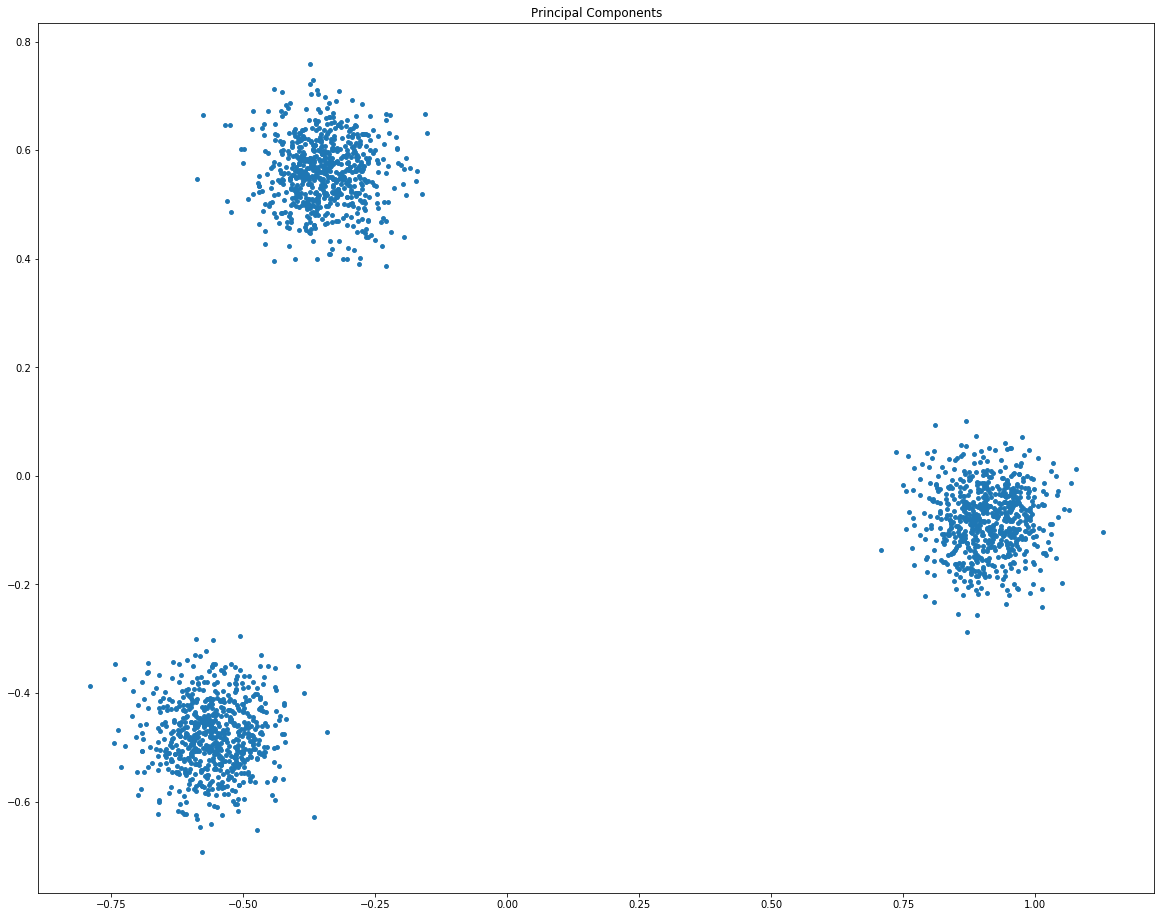

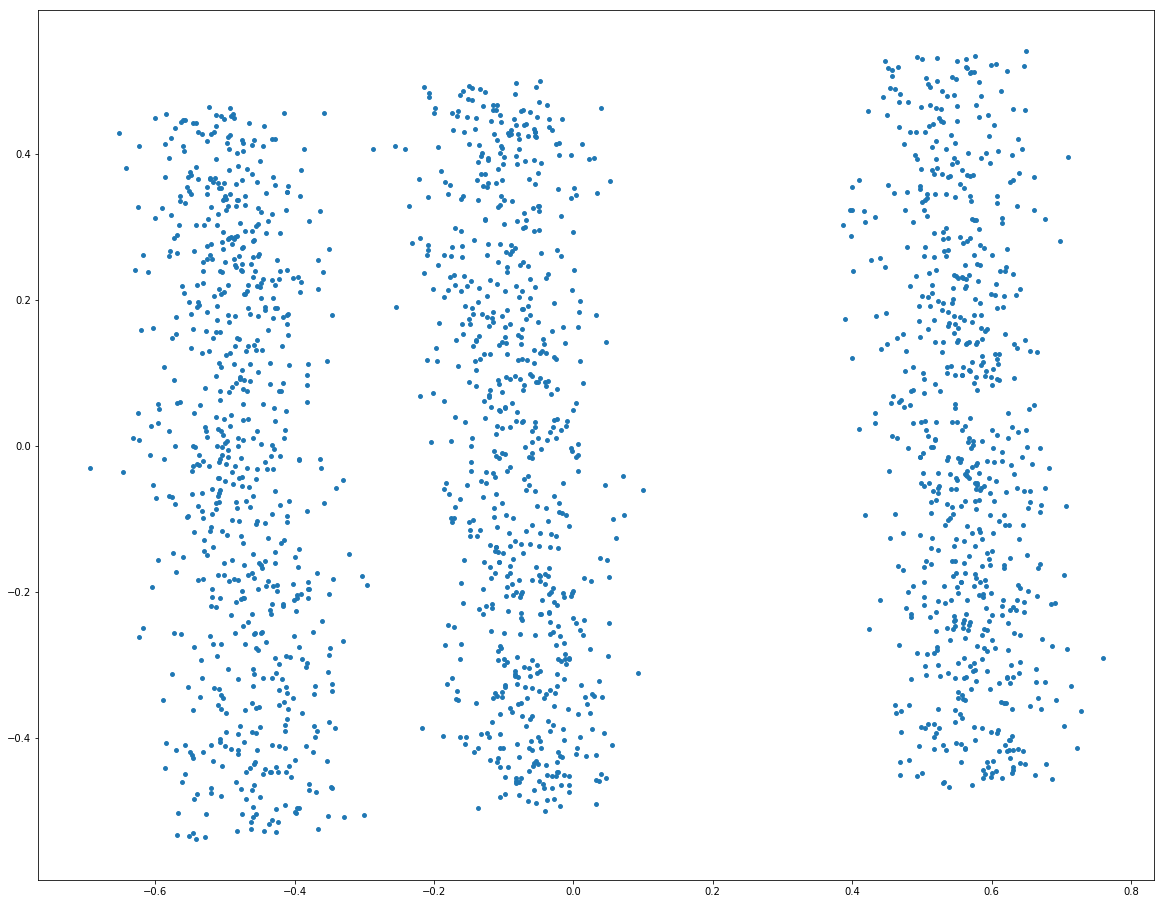

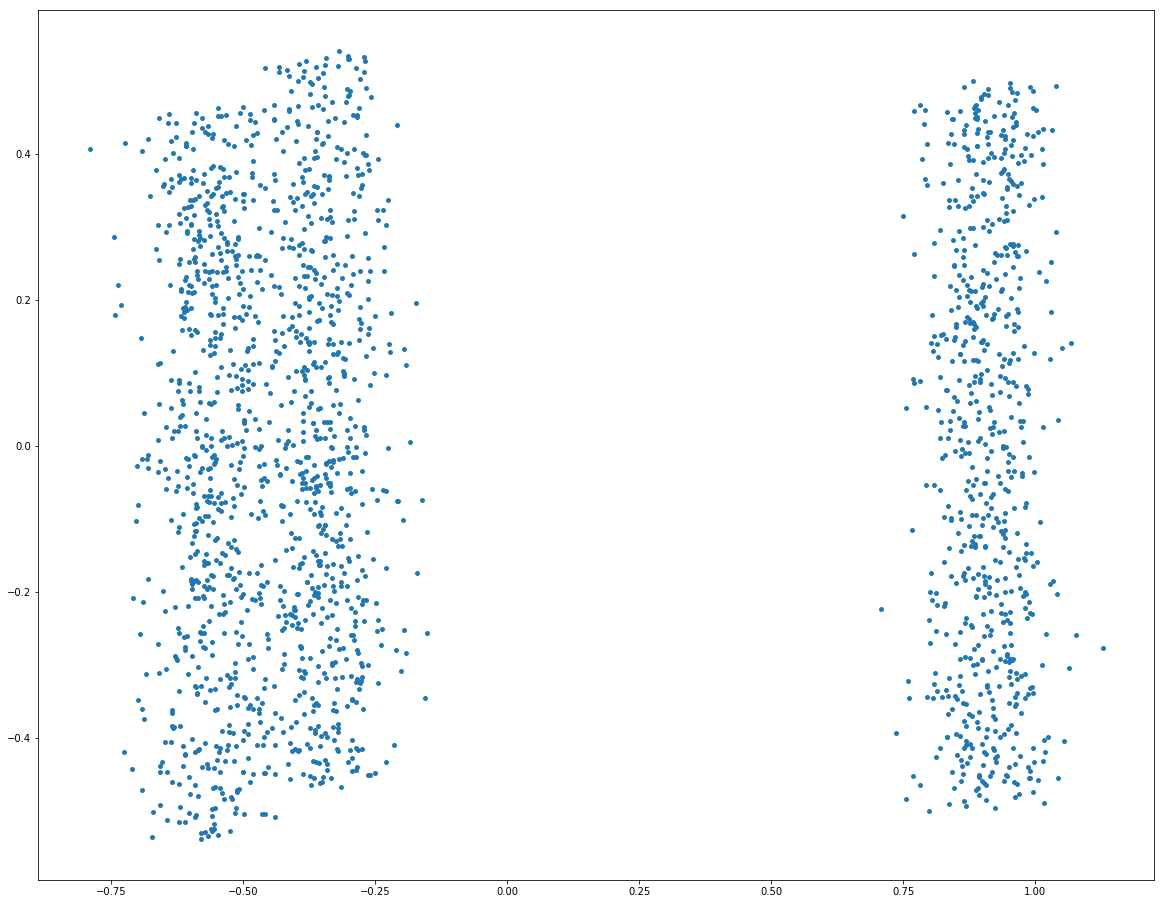

In [42]:
#perform Principal Components Analysis
pca = PCA(n_components=3).fit(df3)
pca_2d = pca.transform(df3)
    
#do eigenvalue composition to find the variables that contribute most
#
#
#
#

#plot the PCA
fig=plt.figure(figsize=(20, 16))

plt.scatter(pca_2d[:,0], pca_2d[:,1], s=15, cmap='nipy_spectral')
plt.title('Principal Components')
plt.show()

fig=plt.figure(figsize=(20, 16))
plt.scatter(pca_2d[:,1], pca_2d[:,2], s=15, cmap='nipy_spectral')
plt.show()

fig=plt.figure(figsize=(20, 16))
plt.scatter(pca_2d[:,0], pca_2d[:,2], s=15, cmap='nipy_spectral')
plt.show()

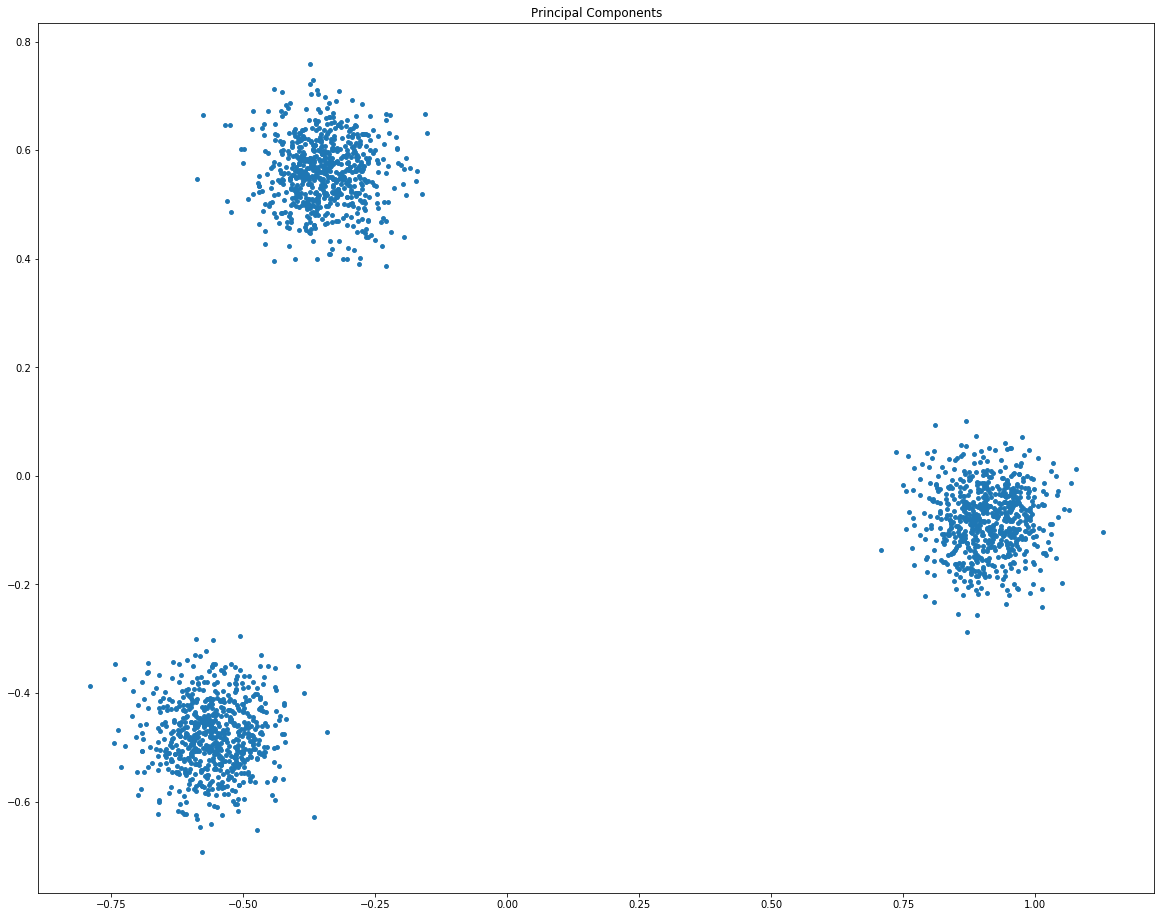

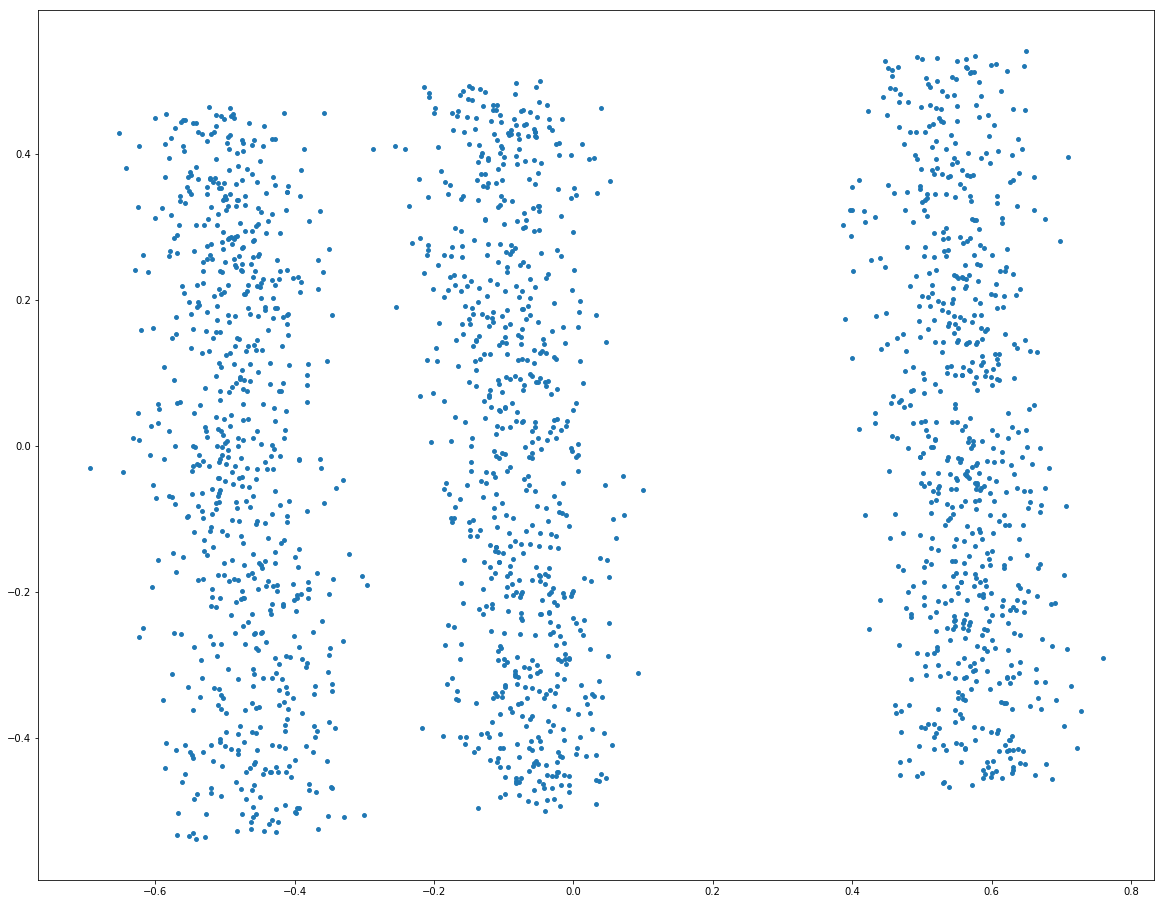

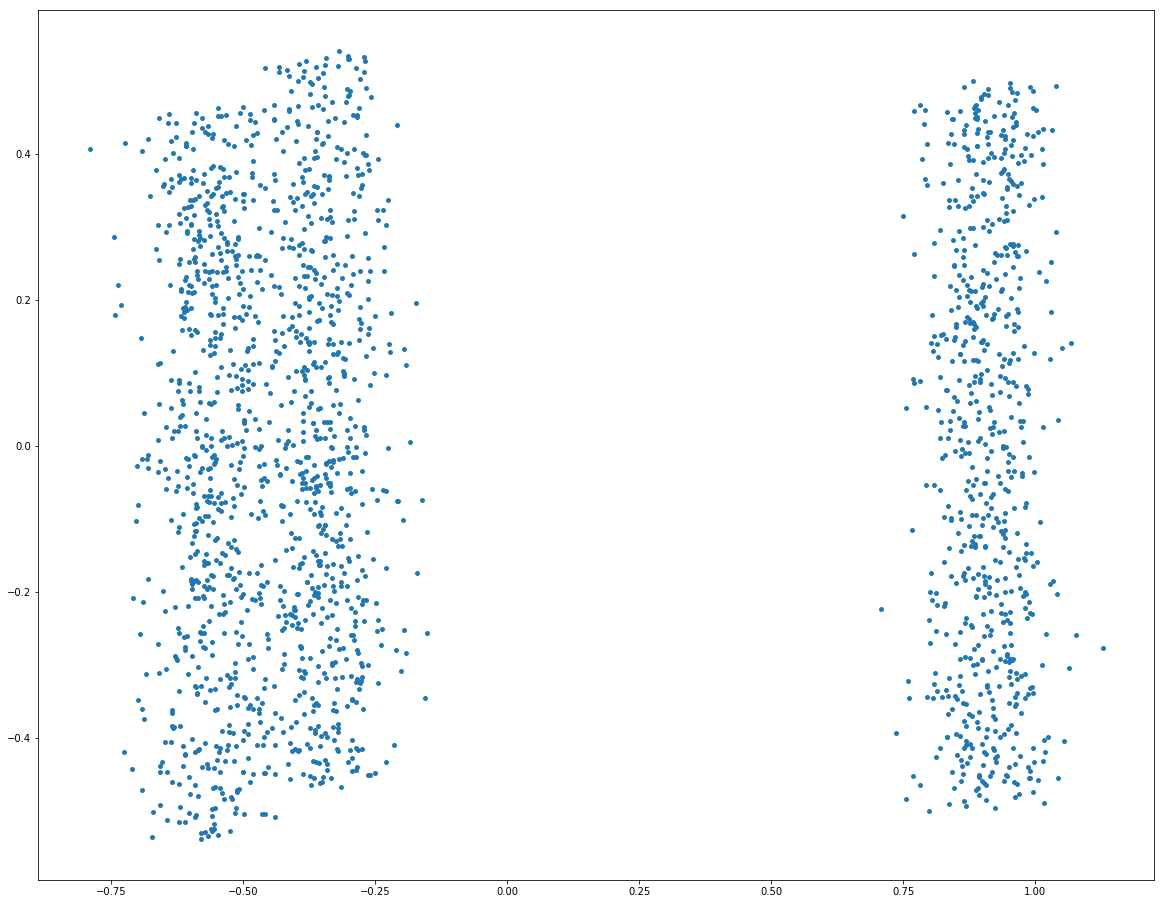

In [43]:
#In some cases it can be necessary to clean out outliers. Using the PCA values is the most thorough way of doing this
 
#Add PCA scores to data as variables
PCA_Vars=['PCA_1'
         ,'PCA_2'
         ,'PCA_3']
PCA_1=pca_2d[:,0]
PCA_2=pca_2d[:,1]
PCA_3=pca_2d[:,2]

df3['index']=df3.index.values
df3['PCA_1']=PCA_1
df3['PCA_2']=PCA_2
df3['PCA_3']=PCA_3


#remove outliers via PCA scores
outliers=[]
outlier_pct=0

for k in PCA_Vars:
    outliers.append(df3['index'][(df3[k] < df3[k].quantile(outlier_pct/100)) | (df3[k] > df3[k].quantile(1-(outlier_pct/100)))])
outliers_flat = [item for sublist in outliers for item in sublist] 
df3_trunc=df3[~df3.index.isin(outliers_flat)]
#df3_trunc=df3[~df3.index.isin(outliers_flat)][cluster_var]

#plot the truncated values
fig=plt.figure(figsize=(20, 16))

plt.scatter(df3_trunc[df3_trunc.columns[-3]], df3_trunc[df3_trunc.columns[-2]], s=15, cmap='nipy_spectral')
plt.title('Principal Components')
plt.show()

#note - one could also just write df3_trunc['PCA_1'] etc., but this is just to show a different way of doing things

fig=plt.figure(figsize=(20, 16))
plt.scatter(df3_trunc[df3_trunc.columns[-2]], df3_trunc[df3_trunc.columns[-1]], s=15, cmap='nipy_spectral')
plt.show()

fig=plt.figure(figsize=(20, 16))
plt.scatter(df3_trunc[df3_trunc.columns[-3]], df3_trunc[df3_trunc.columns[-1]], s=15, cmap='nipy_spectral')
plt.show()

#drop the PCA scores so they don't get double counted in the clustering
del df3
temp=df3_trunc.drop(['PCA_1','PCA_2','PCA_3','index'], axis=1)
df3=temp

## Perform clustering using DBSCAN or HDBSCAN

In [44]:
#(vary the epsilon parameter and the sample size)
dbscanner = DBSCAN(eps=1, min_samples=45).fit(df3)
labels = dbscanner.labels_
print(len(set(labels)))

2


In [45]:
# Perform clustering using HDBSCAN - less flexible but the most accurate
hdbscanner = hdbscan.HDBSCAN(min_cluster_size=50).fit(df3)
labels = hdbscanner.labels_

In [46]:
#some info about the clustering
silhouette_avg = silhouette_score(df3, labels)

noise=[i for i,x in enumerate(list(Counter(labels).keys())) if x == -1]
if len(noise)<1:
    num_noise=0
else: 
    num_noise=list(Counter(labels).values())[noise[0]]

print("Number of clusters : ", len(set(labels)),
      "Number of points assigned to noise : ", num_noise,
      "The average silhouette_score is :", silhouette_avg)

Number of clusters :  3 Number of points assigned to noise :  0 The average silhouette_score is : 0.602514117976958


## Evaluate the clustering

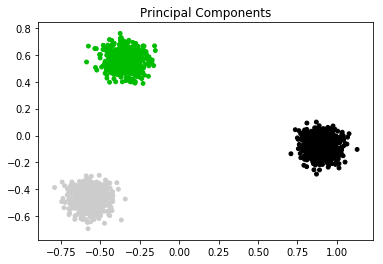

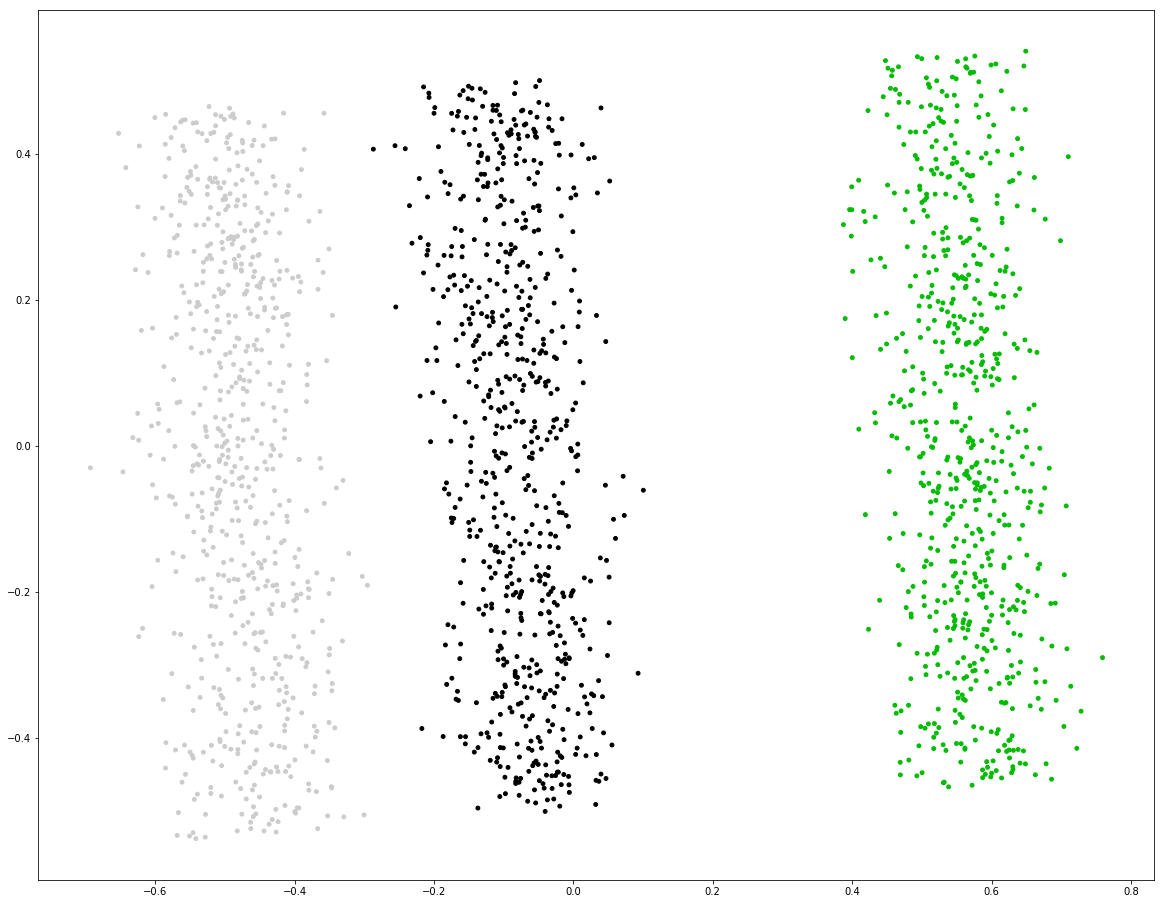

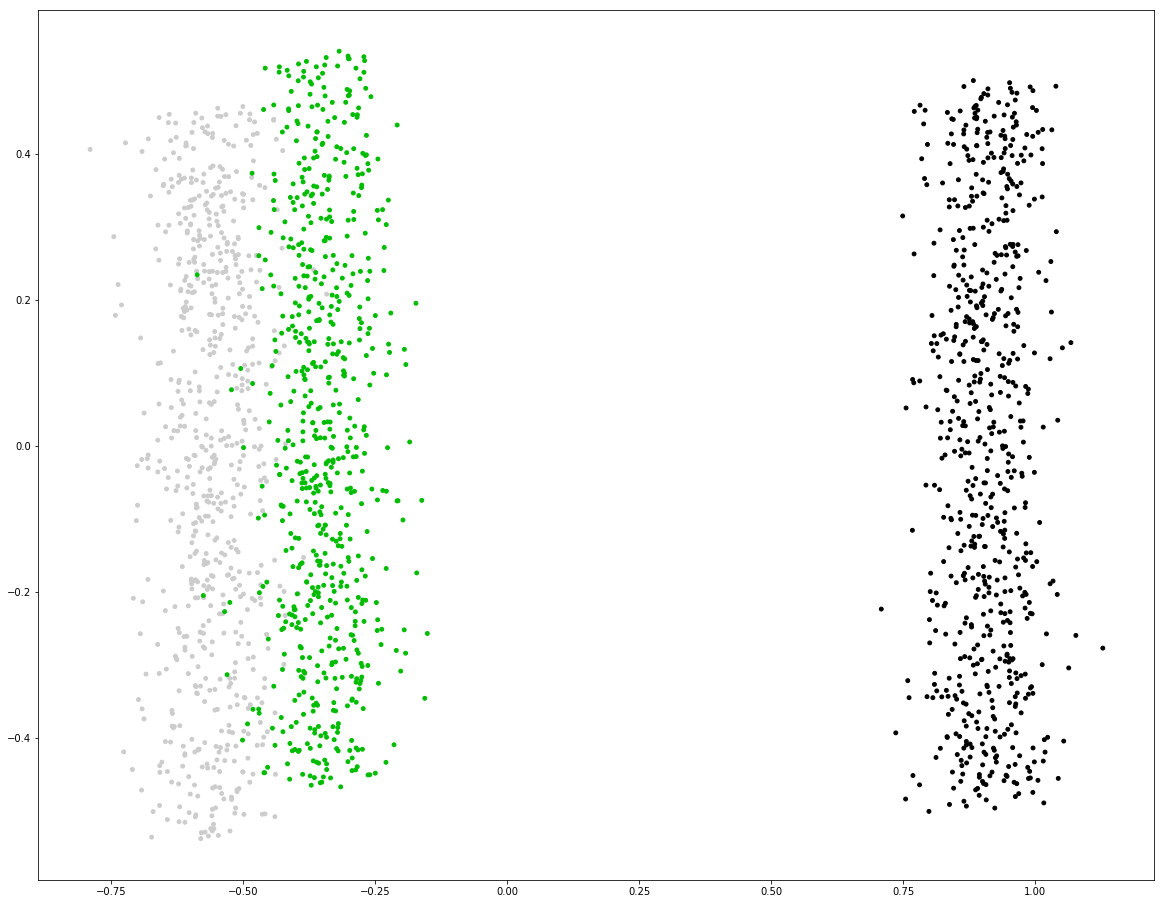

In [47]:
#plot the clusters - the data points are colored by the cluster they are infig=plt.figure(figsize=(20, 16))

plt.scatter(df3_trunc[df3_trunc.columns[-3]], df3_trunc[df3_trunc.columns[-2]], s=15, c=labels, cmap='nipy_spectral')
plt.title('Principal Components')
plt.show()

fig=plt.figure(figsize=(20, 16))
plt.scatter(df3_trunc[df3_trunc.columns[-2]], df3_trunc[df3_trunc.columns[-1]], s=15, c=labels, cmap='nipy_spectral')
plt.show()

fig=plt.figure(figsize=(20, 16))
plt.scatter(df3_trunc[df3_trunc.columns[-3]], df3_trunc[df3_trunc.columns[-1]], s=15, c=labels, cmap='nipy_spectral')
plt.show()

In [48]:
#Add the clusters to the data and remove the noise
cluster_ID = []
for label in labels:
    cluster_ID.append(label)
        
#create a copy of the dataset and add cluster_ID's to the dataset 
df4 = df3.copy()

df4.loc[:, 'clusterID'] = cluster_ID

#noise in DBSCAN is given "cluster" -1, these are removed
df4=df4[df4['clusterID'] != -1]
labels_clean = labels[np.logical_not(labels==-1)]

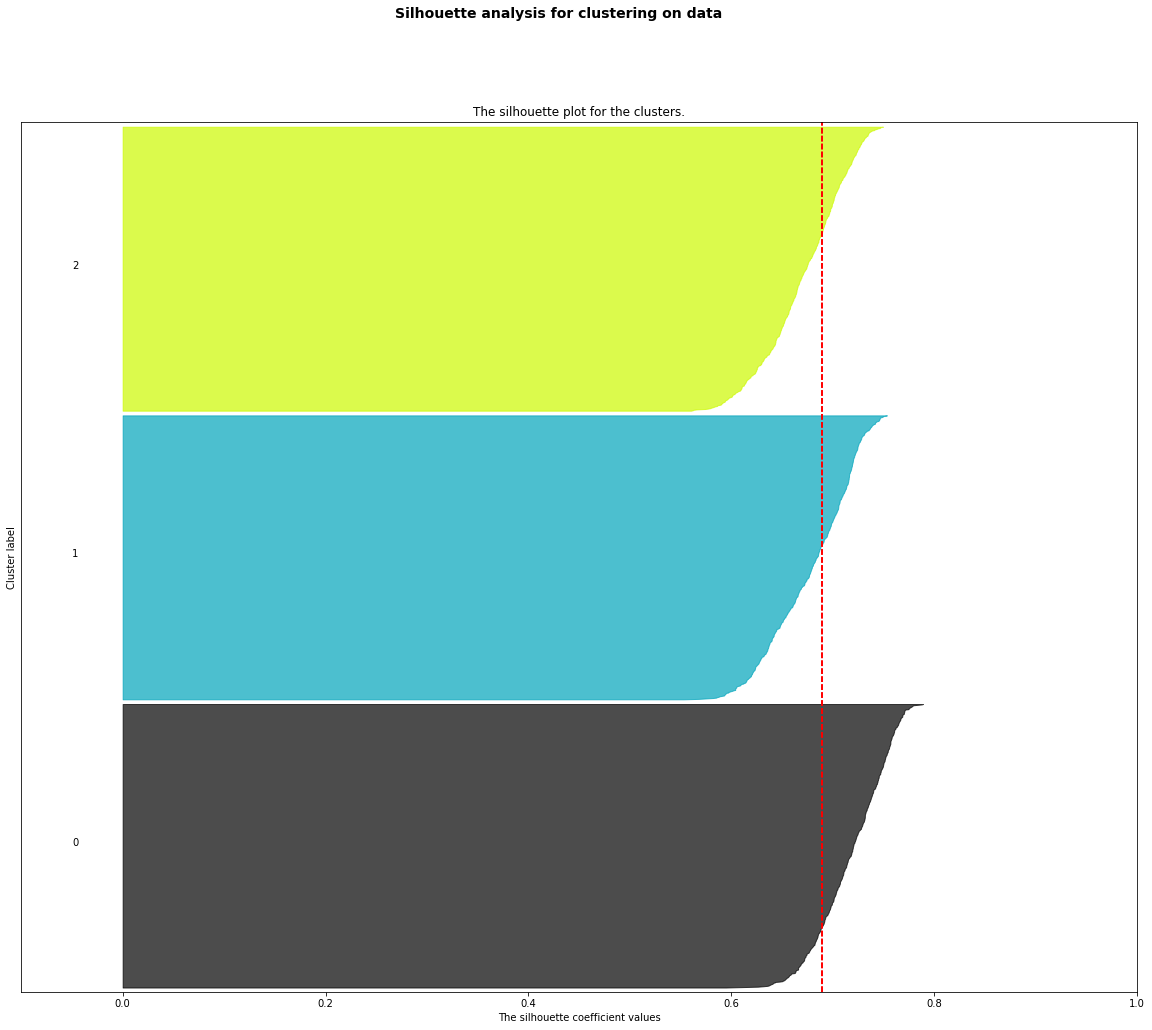

In [49]:
#Do a silouette plot - gives an idea over how "tight" the clusters are

fig, (ax1) = plt.subplots(1)
fig.set_size_inches(20, 16)
num_clusters = len(set(labels_clean))
sample_silhouette_values = silhouette_samples(df4, labels_clean)
silhouette_avg_no_noise = silhouette_score(df4, labels)
    
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(df4) + (num_clusters + 1) * 10])

y_lower = 10

for i in range(num_clusters):
    cluster_sil_val = sample_silhouette_values[labels_clean == i]

    # sort clusters by sihouette score
    cluster_sil_val.sort()

    #find out where to put the rows
    cluster_shape = cluster_sil_val.shape[0]
    y_upper = y_lower + cluster_shape

    #Fill an area with colored rows with the length of each row corresponding to the value of the silouette score
    color = cm.spectral(float(i) / num_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_sil_val,
                     facecolor=color, edgecolor=color, alpha=0.7)

    # Add the cluster number 
    ax1.text(-0.05, y_lower + 0.5 * cluster_shape, str(i))

    # Find the lower limit for the next clusters (spaced by 10)
    y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # Insert a line for "average" with the average silhouette score
    ax1.axvline(x=silhouette_avg_no_noise, color="red", linestyle="--")
    ax1.set_yticks([])  
plt.suptitle(("Silhouette analysis for clustering on data "),fontsize=14, fontweight='bold')
plt.show()

## Explaining the clustering

In [50]:
#Try to explain the clusters by running a decision tree algoritm on them 

X = df4.drop('clusterID', axis=1)
y = df4['clusterID']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#Fit to decision tree
clf = tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
clf = clf.fit(X, y)

#Get predictions and check accuracy
y_predict = clf.predict(X_test)
print("Accuracy score is:", accuracy_score(y_test, y_predict))


Accuracy score is: 1.0


In [ ]:
'''
#draw the decision tree 
dotfile = StringIO()

tree.export_graphviz(clf, out_file=dotfile, feature_names=X.columns, filled=True, rounded=True) #, special_chracters=True

graph = pydotplus.graph_from_dot_data(dotfile.getvalue())  
#(graph,)=pydot.graph_from_dot_data(dotfile.getvalue())
#graph.write_png("dtree.png")
Image(graph.create_png())

# Visualize tree in notebok (it is too big to navigate)
#with open("tree.dot") as f:
#    dot_graph = f.read()
#graphviz.Source(dot_graph) 
Det var det her der virkede i sin tid
ups
nej
# Fit and draw tree
#clf = tree.DecisionTreeClassifier(max_depth=5)
#clf = clf.fit(co_claim_train, co_claim_y_train)
tree.export_graphviz(clf, out_file='tree.dot') 
check_call(['dot','-Tpng','tree.dot','-o','OutputFile.png']) 
#Det er den sidste der kører'''

In [51]:
#Rewrite clusters as a series of business rules

#some code to make the output easier to read
def tree_to_code(tree, feature_names, table_name):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    #print("def tree({}):".format(", ".join(feature_names)))
    print("Clustering of table {} broken down by business rules:".format(table_name))
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

#write tree as series of "if-then statements" - you would want the returned arrays to be close to one number and the rest zeroes with one
tree_to_code(clf, X.columns, "df4")

Clustering of table df4 broken down by business rules:
  if 6 <= 0.35142843425273895:
    return [[  0. 667.   0.]]
  else:  # if 6 > 0.35142843425273895
    if 8 <= 0.4847976416349411:
      return [[666.   0.   0.]]
    else:  # if 8 > 0.4847976416349411
      return [[  0.   0. 667.]]


In [ ]:
#import sys
#!{sys.executable} -m pip install pydotplus